--Penerapan algoritma Decision Tree = tanpa hyper parameter tuning

*IMPORT LIBRARY*

In [5]:
#input libarary
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pyswarms as ps
import time as time

from sklearn.tree import plot_tree
from sklearn import metrics
from sklearn.impute import SimpleImputer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,  classification_report, precision_score, recall_score, f1_score

In [6]:
df = pd.read_csv('kidney_disease.csv')
df.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,35,7300,4.6,no,no,no,good,no,no,ckd


*DATA UNDERSTANDING*

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              400 non-null    int64  
 1   age             391 non-null    float64
 2   bp              388 non-null    float64
 3   sg              353 non-null    float64
 4   al              354 non-null    float64
 5   su              351 non-null    float64
 6   rbc             248 non-null    object 
 7   pc              335 non-null    object 
 8   pcc             396 non-null    object 
 9   ba              396 non-null    object 
 10  bgr             356 non-null    float64
 11  bu              381 non-null    float64
 12  sc              383 non-null    float64
 13  sod             313 non-null    float64
 14  pot             312 non-null    float64
 15  hemo            348 non-null    float64
 16  pcv             330 non-null    object 
 17  wc              295 non-null    obj

In [8]:
print('Data Shape :',df.shape)

Data Shape : (400, 26)


In [9]:
df.classification.value_counts() 

classification
ckd       248
notckd    150
ckd\t       2
Name: count, dtype: int64

In [10]:
# memastikan bahwa classificationkolom hanya berisi maknackddan notckd)
df['classification'] = df['classification'].replace('ckd\t','notckd')
df.classification.value_counts()

classification
ckd       248
notckd    152
Name: count, dtype: int64

In [11]:
#misahkan fitur dan label, semua atribut kecuali label class 
ind_col = [col for col in df.columns if col != 'Class']
dep_col = 'Class'

*CLEANING*

missing value, cek duplikat, transformasi data,split data

In [12]:
# Menghapus Kolom yang Tidak Relevan
df.drop('id', axis=1, inplace=True)

In [13]:
# Cek missing values
print("\nNilai Hilang di Setiap Kolom:")
print(df.isna().sum().sort_values(ascending = False))


Nilai Hilang di Setiap Kolom:
rbc               152
rc                130
wc                105
pot                88
sod                87
pcv                70
pc                 65
hemo               52
su                 49
sg                 47
al                 46
bgr                44
bu                 19
sc                 17
bp                 12
age                 9
ba                  4
pcc                 4
htn                 2
dm                  2
cad                 2
appet               1
pe                  1
ane                 1
classification      0
dtype: int64


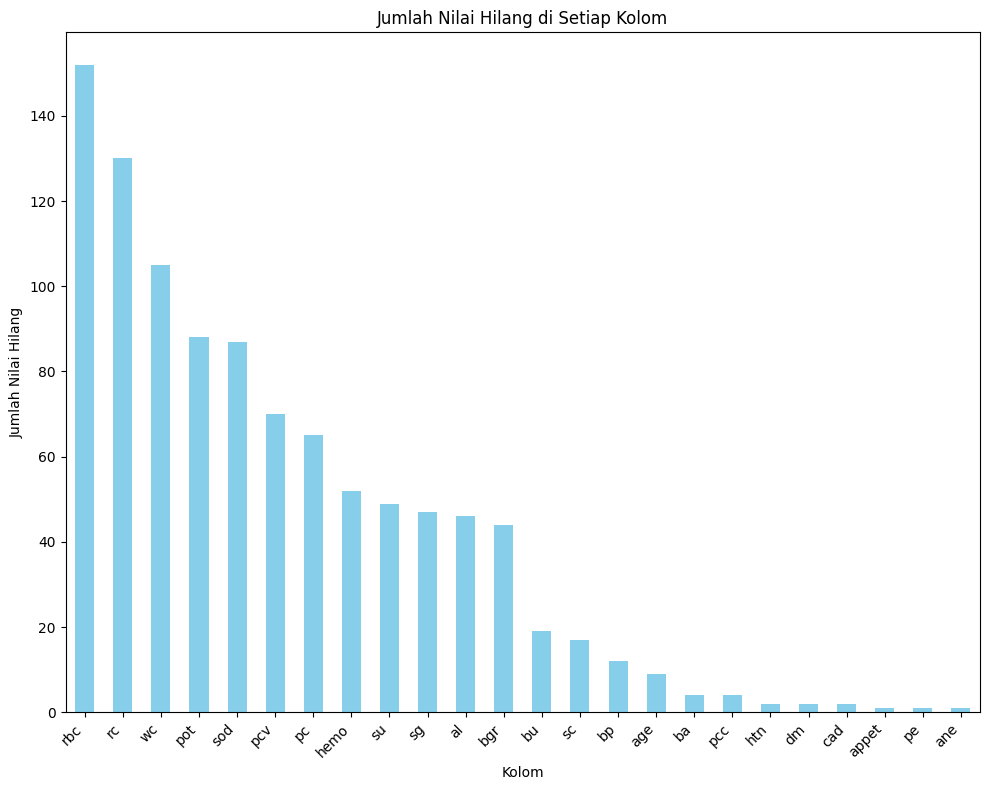

In [14]:
import matplotlib.pyplot as plt

# Menghitung nilai hilang di setiap kolom
missing_values = df.isna().sum()
missing_values = missing_values[missing_values > 0]  # Hanya kolom dengan nilai hilang

# Plot bar chart
plt.figure(figsize=(10, 8))
missing_values.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title("Jumlah Nilai Hilang di Setiap Kolom")
plt.xlabel("Kolom")
plt.ylabel("Jumlah Nilai Hilang")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Handling missing value dengan menggunakan 2 metode:

1. missing value pada data kategorikal menggunakan library sklean yaitu simpleputer dengan parameter most_frequent sehingga data kategorikal yang hilang akan terisi dengan data yang sering muncul (modus)

2. missing value pada data numerikal menggunakan librart sklean yaitu simpleputer, dengan paramaeter mean sehingga data numerikal yang hilang akan terisi dengan nilai rata-rata (mean)

In [15]:
#membuat daftar cat_col yang bertipe data ( dtype) object
cat_col = [col for col in df.columns if df[col].dtype == 'object'] 

#membuat daftar num_col yang tipe datanya tidak ada object (seperti int64/float64).
num_col = [col for col in df.columns if df[col].dtype != 'object']

In [16]:
# Memeriksa Tipe Data dan Mengonversi Jika Diperlukan
print("\nTipe Data Setiap Kolom:")
print(df.dtypes)


Tipe Data Setiap Kolom:
age               float64
bp                float64
sg                float64
al                float64
su                float64
rbc                object
pc                 object
pcc                object
ba                 object
bgr               float64
bu                float64
sc                float64
sod               float64
pot               float64
hemo              float64
pcv                object
wc                 object
rc                 object
htn                object
dm                 object
cad                object
appet              object
pe                 object
ane                object
classification     object
dtype: object


In [17]:
cat_col

['rbc',
 'pc',
 'pcc',
 'ba',
 'pcv',
 'wc',
 'rc',
 'htn',
 'dm',
 'cad',
 'appet',
 'pe',
 'ane',
 'classification']

In [18]:
#handling missing value pada kategorik dengan most_frequent
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')
imputer = imputer.fit(df[cat_col])
df[cat_col] = imputer.transform(df[cat_col])

In [19]:
#cek missing value pada data kategorik
df[cat_col].isnull().sum()

rbc               0
pc                0
pcc               0
ba                0
pcv               0
wc                0
rc                0
htn               0
dm                0
cad               0
appet             0
pe                0
ane               0
classification    0
dtype: int64

In [20]:
num_col

['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo']

In [21]:
# Encoding data Kategorikal
# mengubah nilai kategori menjadi format numerik
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()

df['rbc'] = lb.fit_transform(df['rbc'])
df['pc'] = lb.fit_transform(df['pc'])
df['pcc'] = lb.fit_transform(df['pcc'])
df['ba'] = lb.fit_transform(df['ba'])
df['pcv'] = lb.fit_transform(df['pcv'])
df['wc'] = lb.fit_transform(df['wc'])
df['rc'] = lb.fit_transform(df['rc'])
df['htn'] = lb.fit_transform(df['htn'])
df['dm'] = lb.fit_transform(df['dm'])
df['cad'] = lb.fit_transform(df['cad'])
df['appet'] = lb.fit_transform(df['appet'])
df['pe'] = lb.fit_transform(df['pe'])
df['ane'] = lb.fit_transform(df['ane'])
df['classification'] = lb.fit_transform(df['classification'])



In [22]:
#handling missing value pada kategorik dengan nilai rata-rata "mean"
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
imputer = imputer.fit(df[num_col])
df[num_col] = imputer.transform(df[num_col])

In [23]:
df[num_col].isnull().sum()

age     0
bp      0
sg      0
al      0
su      0
bgr     0
bu      0
sc      0
sod     0
pot     0
hemo    0
dtype: int64

In [24]:
# Memastikan tidak ada lagi nilai kosong pada keseluruhan data
print("\nSetelah Menangani Nilai Kosong:")
print(df.isna().sum().sort_values(ascending = False))


Setelah Menangani Nilai Kosong:
age               0
pot               0
ane               0
pe                0
appet             0
cad               0
dm                0
htn               0
rc                0
wc                0
pcv               0
hemo              0
sod               0
bp                0
sc                0
bu                0
bgr               0
ba                0
pcc               0
pc                0
rbc               0
su                0
al                0
sg                0
classification    0
dtype: int64


In [25]:
df.duplicated().sum()

0

In [26]:
# Memeriksa Tipe Data kembali setelah di transformasi
print("\nTipe Data Setiap Kolom:")
print(df.dtypes)


Tipe Data Setiap Kolom:
age               float64
bp                float64
sg                float64
al                float64
su                float64
rbc                 int32
pc                  int32
pcc                 int32
ba                  int32
bgr               float64
bu                float64
sc                float64
sod               float64
pot               float64
hemo              float64
pcv                 int32
wc                  int32
rc                  int32
htn                 int32
dm                  int32
cad                 int32
appet               int32
pe                  int32
ane                 int32
classification      int32
dtype: object


In [27]:
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,48.0,80.0,1.020,1.0,0.0,1,1,0,0,121.000000,...,32,72,34,1,4,1,0,0,0,0
1,7.0,50.0,1.020,4.0,0.0,1,1,0,0,148.036517,...,26,56,34,0,3,1,0,0,0,0
2,62.0,80.0,1.010,2.0,3.0,1,1,0,0,423.000000,...,19,70,34,0,4,1,1,0,1,0
3,48.0,70.0,1.005,4.0,0.0,1,0,1,0,117.000000,...,20,62,19,1,3,1,1,1,1,0
4,51.0,80.0,1.010,2.0,0.0,1,1,0,0,106.000000,...,23,68,27,0,3,1,0,0,0,0


In [28]:
# mengganti nama data dan menetapkan nama asli
df_columns= [
    'Umur',
    'Tekanan_Darah',
    'Berat_Badan',
    'Albumin',
    'Gula',
    'Sel_Darah_Merah',
    'Sel_Nanah',
    'Gumpalan_Sel_Nanah',
    'Bacteri',
    'Glukosa_Darah_Acak',
    'Urea_Darah',
    'Serum_Kreatinin',
    'Sodium',
    'Kalium',
    'Haemoglobin',
    'Volume_Sel_yang_Dikemas',
    'Jumlah_Sel_Darah_Putih',
    'Jumlah_Sel_Darah_Merah',
    'Hipertensi',
    'Diabetes_Mellitus',
    'Penyakit_Arteri_Koroner',
    'Nafsu_Makan',
    'Pedal_Edema',
    'Anemia',
    'Class',]

df.columns = df_columns

In [29]:
#menyimpan data yang telah dibersihkan tanpa missing value
df.to_csv('Kronis.csv',index=False)

In [30]:
print('Data Shape :',df.shape)

Data Shape : (400, 25)


In [31]:
df.Class.value_counts()


Class
0    248
1    152
Name: count, dtype: int64

*SPLIT DATASET*

In [32]:
df = pd.read_csv('Kronis.csv')
df.head(10)

,Umur,Tekanan_Darah,Berat_Badan,Albumin,Gula,Sel_Darah_Merah,Sel_Nanah,Gumpalan_Sel_Nanah,Bacteri,Glukosa_Darah_Acak,...,Volume_Sel_yang_Dikemas,Jumlah_Sel_Darah_Putih,Jumlah_Sel_Darah_Merah,Hipertensi,Diabetes_Mellitus,Penyakit_Arteri_Koroner,Nafsu_Makan,Pedal_Edema,Anemia,Class
0,48.0,80.000000,1.020,1.0,0.0,1,1,0,0,121.000000,...,32,72,34,1,4,1,0,0,0,0
1,7.0,50.000000,1.020,4.0,0.0,1,1,0,0,148.036517,...,26,56,34,0,3,1,0,0,0,0
2,62.0,80.000000,1.010,2.0,3.0,1,1,0,0,423.000000,...,19,70,34,0,4,1,1,0,1,0
3,48.0,70.000000,1.005,4.0,0.0,1,0,1,0,117.000000,...,20,62,19,1,3,1,1,1,1,0
4,51.0,80.000000,1.010,2.0,0.0,1,1,0,0,106.000000,...,23,68,27,0,3,1,0,0,0,0
5,60.0,90.000000,1.015,3.0,0.0,1,1,0,0,74.000000,...,27,72,25,1,4,1,0,1,0,0
6,68.0,70.000000,1.010,0.0,0.0,1,1,0,0,100.000000,...,24,90,34,0,3,1,0,0,0,0
7,24.0,76.469072,1.015,2.0,4.0,1,0,0,0,410.000000,...,32,64,31,0,4,1,0,1,0,0
8,52.0,100.000000,1.015,3.0,0.0,1,0,1,0,138.000000,...,21,88,21,1,4,1,0,0,1,0
9,53.0,90.000000,1.020,2.0,0.0,0,0,1,0,70.000000,...,17,18,17,1,4,1,1,0,1,0


In [33]:
# Memisahkan fitur dan target
X = np.array(df.drop(['Class'], axis=1))  # Fitur x
y = np.array(df['Class'])  # Target

In [34]:
#Pembagian Dataset 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 5)
X_train.shape, X_test.shape

((320, 24), (80, 24))

#pembagian data 80:20 

Training set: 320 sampel dengan 24 fitur digunakan untuk melatih model.
Testing set: 80 sampel dengan 24 fitur digunakan untuk menguji kinerja model.

SMOTE

2025-01-23 20:00:35,253 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


C:\Users\A S U S\AppData\Local\Temp\ipykernel_20392\455193081.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Class', y='Percentage', data=class_percentages, palette='pastel')
2025-01-23 20:00:35,269 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


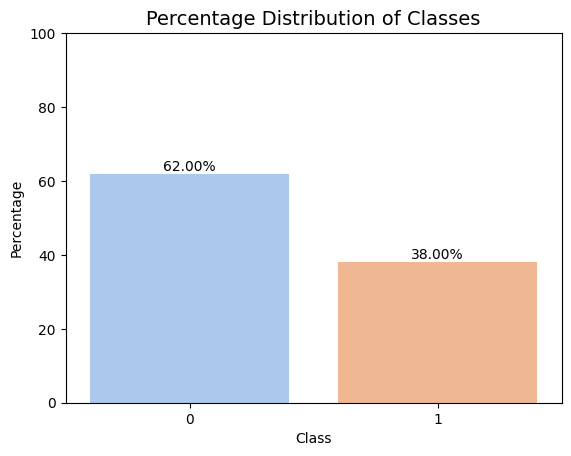

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Menghitung persentase distribusi kelas
class_percentages = (df['Class'].value_counts(normalize=True) * 100).reset_index()
class_percentages.columns = ['Class', 'Percentage']

# Membuat plot dengan persentase
sns.barplot(x='Class', y='Percentage', data=class_percentages, palette='pastel')

# Menambahkan nilai persentase di atas bar
for index, row in class_percentages.iterrows():
    plt.text(x=index, y=row['Percentage'], s=f"{row['Percentage']:.2f}%", ha='center', va='bottom')

# Menambahkan judul dan label
plt.title("Percentage Distribution of Classes", fontsize=14)
plt.xlabel("Class")
plt.ylabel("Percentage")
plt.ylim(0, 100)  # Skala y dari 0 hingga 100
plt.show()


C:\Users\A S U S\AppData\Local\Temp\ipykernel_20392\4159872634.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Class', y='Count', data=class_counts, palette='pastel')


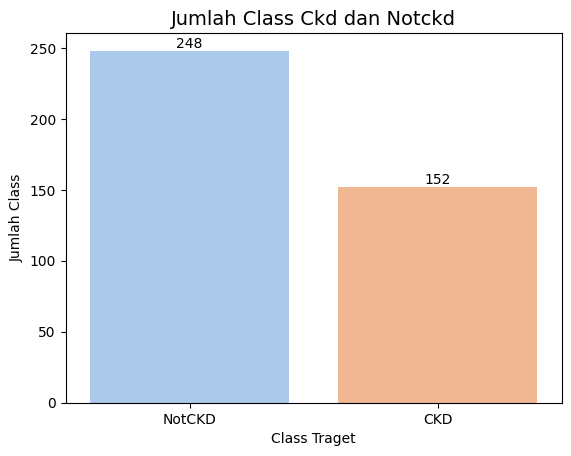

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Mengganti nilai pada kolom 'Class' dengan label
df['Class'] = df['Class'].replace({0: 'NotCKD', 1: 'CKD'})

# Menghitung jumlah data di setiap kelas
class_counts = df['Class'].value_counts().reset_index()
class_counts.columns = ['Class', 'Count']

# Membuat plot dengan jumlah data
sns.barplot(x='Class', y='Count', data=class_counts, palette='pastel')

# Menambahkan nilai jumlah di atas bar
for index, row in class_counts.iterrows():
    plt.text(x=index, y=row['Count'], s=row['Count'], ha='center', va='bottom')

# Menambahkan judul dan label
plt.title("Jumlah Class Ckd dan Notckd", fontsize=14)
plt.xlabel("Class Traget")
plt.ylabel("Jumlah Class")
plt.show()


In [37]:
from imblearn.over_sampling import SMOTE
import pandas as pd

# Separate features and target
X = df.drop('Class', axis=1)  # Replace 'HeartDisease' with your target column name
y = df['Class']

# Create a SMOTE object
smote = SMOTE(random_state=5)

# Fit and apply SMOTE to the data
X_train_smote, y_train_smote = smote.fit_resample(X, y)

# Create a new DataFrame with the resampled data
smote_data = pd.DataFrame(X_train_smote, columns=X.columns)
smote_data['Class'] = y_train_smote

# Print the class distribution in the resampled data
print(smote_data['Class'].value_counts())


Class
NotCKD    248
CKD       248
Name: count, dtype: int64


C:\Users\A S U S\AppData\Local\Temp\ipykernel_20392\2879907502.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='pastel')


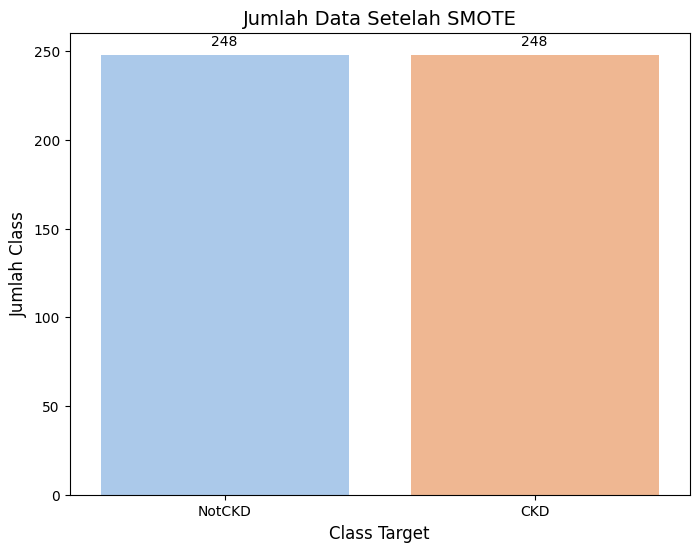

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Hitung distribusi kelas
class_counts = smote_data['Class'].value_counts()

# Membuat diagram batang
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='pastel')

# Tambahkan label pada setiap batang
for i, count in enumerate(class_counts.values):
    plt.text(i, count + 5, f'{count}', ha='center', fontsize=10, color='black')

# Tambahkan judul dan label
plt.title('Jumlah Data Setelah SMOTE', fontsize=14)
plt.xlabel('Class Target', fontsize=12)
plt.ylabel('Jumlah Class', fontsize=12)
plt.xticks(ticks=class_counts.index, labels=['NotCKD', 'CKD'])  # Sesuaikan label kelas
plt.show()


splitt data

In [39]:
x = df.drop(['Class'],axis=1) # x nya adalah atribut yang mempengaruhi penyakit jantung
y = df['Class'] # y nya adalah label itu sendiri

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)


model decision tree

In [41]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Training model
dt = DecisionTreeClassifier()
dt.fit(X_train_smote, y_train_smote)

# Prediksi
y_pred = dt.predict(X_test)


In [42]:
# Import library yang dibutuhkan
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from imblearn.under_sampling import RandomUnderSampler

# Separate features and target
X = df.drop('Class', axis=1)  # Replace 'HeartDisease' with your target column name
y = df['Class']

# Create a SMOTE object
smote = SMOTE(random_state=5)

# Fit and apply SMOTE to the data
X_train_smote,y_train_smote = smote.fit_resample(X, y)


# Membagi dataset resampled menjadi train dan test set (90% train, 10% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

# Membangun model Decision Tree dengan max_depth = 10
dtc = DecisionTreeClassifier(random_state=5)
 # Melatih model menggunakan data latih
dtc.fit(X_train, y_train)
    
    # Melakukan prediksi dengan data uji
dtc_predictions = dtc.predict(X_test)
    
    # Menghitung metrik evaluasi
accuracy = accuracy_score(y_test, dtc_predictions)
precision = precision_score(y_test, dtc_predictions, average='weighted')    
recall = recall_score(y_test, dtc_predictions, average='weighted')
f1 = f1_score(y_test, dtc_predictions, average='weighted')

# Menampilkan hasil
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 Score: {:.2f}%".format(f1 * 100))

# Menampilkan classification report
print("\nClassification Report:\n", classification_report(y_test, dtc_predictions))

Accuracy: 90.00%
Precision: 90.48%
Recall: 90.00%
F1 Score: 90.01%

Classification Report:
               precision    recall  f1-score   support

         CKD       0.85      0.95      0.90        37
      NotCKD       0.95      0.86      0.90        43

    accuracy                           0.90        80
   macro avg       0.90      0.90      0.90        80
weighted avg       0.90      0.90      0.90        80



*MODEL DECISION TREE* kfold


With 10-Fold Cross-Validation (SMOTE applied on training data in each fold):
Average Accuracy: 95.25%
Average Precision: 95.38%
Average Recall: 95.25%
Average F1 Score: 95.26%


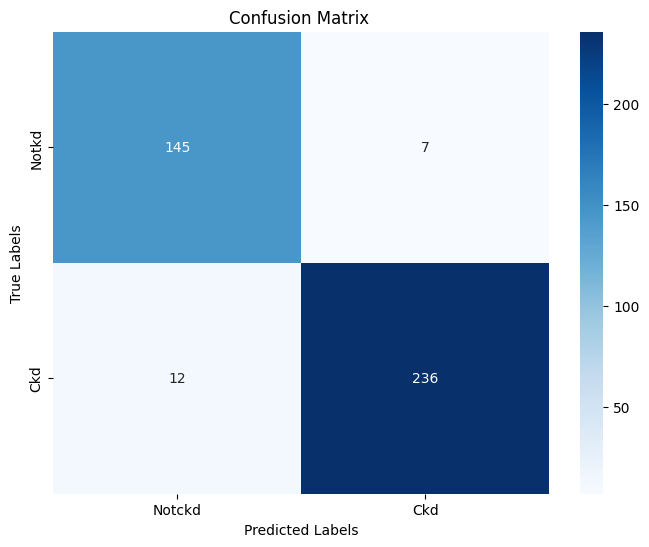

In [43]:
# Import library yang dibutuhkan
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Separate features and target
X = df.drop('Class', axis=1)  # Replace 'Class' with your target column name
y = df['Class']

# Inisialisasi K-Fold
kf = KFold(n_splits=10, shuffle=True, random_state=5)

# List untuk menyimpan hasil dari setiap fold
accuracies = []
precisions = []
recalls = []
f1_scores = []
cumulative_cm = np.zeros((2, 2))  # Menginisialisasi confusion matrix kumulatif

# Melakukan K-Fold Cross Validation
for train_index, test_index in kf.split(X):
    # Membagi data menjadi train dan test berdasarkan indeks fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Terapkan SMOTE hanya pada data latih (X_train, y_train)
    smote = SMOTE(random_state=5)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    # Membuat model Decision Tree
    dtc = DecisionTreeClassifier(max_depth=10, random_state=5)
    
    # Melatih model pada data latih yang telah diresample
    dtc.fit(X_train_resampled, y_train_resampled)
    
    # Melakukan prediksi pada data uji (yang tidak di-resample)
    predictions = dtc.predict(X_test)
    
    # Menghitung metrik evaluasi
    accuracies.append(accuracy_score(y_test, predictions))
    precisions.append(precision_score(y_test, predictions, average='weighted'))
    recalls.append(recall_score(y_test, predictions, average='weighted'))
    f1_scores.append(f1_score(y_test, predictions, average='weighted'))
    
    # Menghitung confusion matrix dan menambahkannya ke matrix kumulatif
    cm = confusion_matrix(y_test, predictions)
    cumulative_cm += cm

# Menghitung rata-rata metrik evaluasi dari semua fold
avg_accuracy = np.mean(accuracies)
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)
avg_f1 = np.mean(f1_scores)

# Menampilkan hasil evaluasi dengan cross-validation
print("\nWith 10-Fold Cross-Validation (SMOTE applied on training data in each fold):")
print("Average Accuracy: {:.2f}%".format(avg_accuracy * 100))
print("Average Precision: {:.2f}%".format(avg_precision * 100))
print("Average Recall: {:.2f}%".format(avg_recall * 100))
print("Average F1 Score: {:.2f}%".format(avg_f1 * 100))

# Menampilkan Confusion Matrix Kumulatif
plt.figure(figsize=(8, 6))
sns.heatmap(cumulative_cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Notckd', 'Ckd'], yticklabels=['Notkd', 'Ckd'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix ')
plt.show()


*MODEL DECISION TREE*

*KLASIFIKASI DECISION TREE DENGAN CRITERION ENTROPY*


In [44]:
dtc_en = DecisionTreeClassifier(criterion='entropy', max_depth= 10, random_state=5)

# fit the model
dtc_en.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=5)

In [45]:
dtc_pred_en = dtc_en.predict(X_test)
print('Model accuracy score with criterion entropy: {0:0.4f}'. format(accuracy_score(y_test, dtc_pred_en)))


Model accuracy score with criterion entropy: 0.9750


In [46]:
dtc_pred_train_en = dtc_en.predict(X_train)
dtc_pred_train_en

array(['NotCKD', 'NotCKD', 'NotCKD', 'NotCKD', 'NotCKD', 'NotCKD',
       'NotCKD', 'NotCKD', 'NotCKD', 'NotCKD', 'NotCKD', 'NotCKD',
       'NotCKD', 'NotCKD', 'NotCKD', 'NotCKD', 'NotCKD', 'NotCKD',
       'NotCKD', 'NotCKD', 'NotCKD', 'NotCKD', 'NotCKD', 'NotCKD',
       'NotCKD', 'NotCKD', 'NotCKD', 'NotCKD', 'NotCKD', 'NotCKD',
       'NotCKD', 'NotCKD', 'CKD', 'NotCKD', 'NotCKD', 'NotCKD', 'NotCKD',
       'NotCKD', 'NotCKD', 'NotCKD', 'NotCKD', 'NotCKD', 'NotCKD',
       'NotCKD', 'NotCKD', 'NotCKD', 'NotCKD', 'NotCKD', 'NotCKD',
       'NotCKD', 'NotCKD', 'NotCKD', 'NotCKD', 'NotCKD', 'NotCKD',
       'NotCKD', 'NotCKD', 'NotCKD', 'NotCKD', 'NotCKD', 'NotCKD',
       'NotCKD', 'NotCKD', 'NotCKD', 'NotCKD', 'NotCKD', 'NotCKD',
       'NotCKD', 'NotCKD', 'NotCKD', 'NotCKD', 'NotCKD', 'NotCKD',
       'NotCKD', 'NotCKD', 'NotCKD', 'NotCKD', 'NotCKD', 'NotCKD',
       'NotCKD', 'NotCKD', 'NotCKD', 'NotCKD', 'NotCKD', 'NotCKD',
       'NotCKD', 'NotCKD', 'NotCKD', 'NotCKD', 'NotCKD'

In [47]:
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, dtc_pred_train_en)))

Training-set accuracy score: 1.0000


In [48]:
# print the scores on training and test set
print('Training set score: {:.4f}'.format(dtc_en.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(dtc_en.score(X_test, y_test)))

Training set score: 1.0000
Test set score: 0.9750


[Text(0.6470588235294118, 0.9375, 'x[14] <= 13.05\nentropy = 0.971\nsamples = 360\nvalue = [144, 216]'),
 Text(0.47058823529411764, 0.8125, 'x[17] <= 35.0\nentropy = 0.278\nsamples = 208\nvalue = [10, 198]'),
 Text(0.29411764705882354, 0.6875, 'x[10] <= 17.5\nentropy = 0.192\nsamples = 203\nvalue = [6, 197]'),
 Text(0.11764705882352941, 0.5625, 'x[12] <= 136.264\nentropy = 0.918\nsamples = 9\nvalue = [3, 6]'),
 Text(0.058823529411764705, 0.4375, 'entropy = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(0.17647058823529413, 0.4375, 'x[13] <= 4.764\nentropy = 0.592\nsamples = 7\nvalue = [1, 6]'),
 Text(0.11764705882352941, 0.3125, 'entropy = 0.0\nsamples = 6\nvalue = [0, 6]'),
 Text(0.23529411764705882, 0.3125, 'entropy = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.47058823529411764, 0.5625, 'x[2] <= 1.016\nentropy = 0.115\nsamples = 194\nvalue = [3, 191]'),
 Text(0.4117647058823529, 0.4375, 'entropy = 0.0\nsamples = 121\nvalue = [0, 121]'),
 Text(0.5294117647058824, 0.4375, 'x[11] <= 1.15\ne

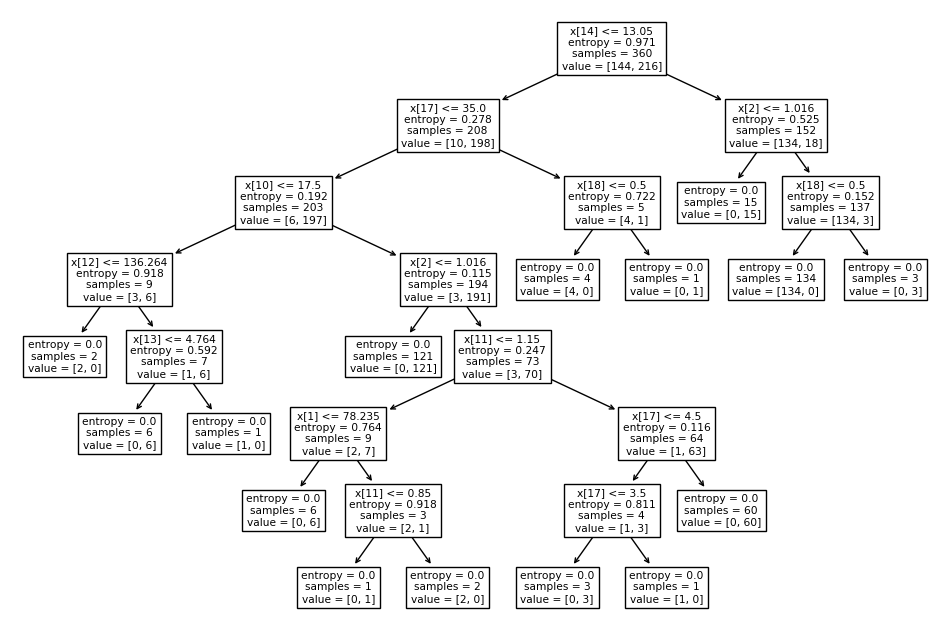

In [49]:
plt.figure(figsize=(12,8))

from sklearn import tree

tree.plot_tree(dtc_en.fit(X_train, y_train)) 

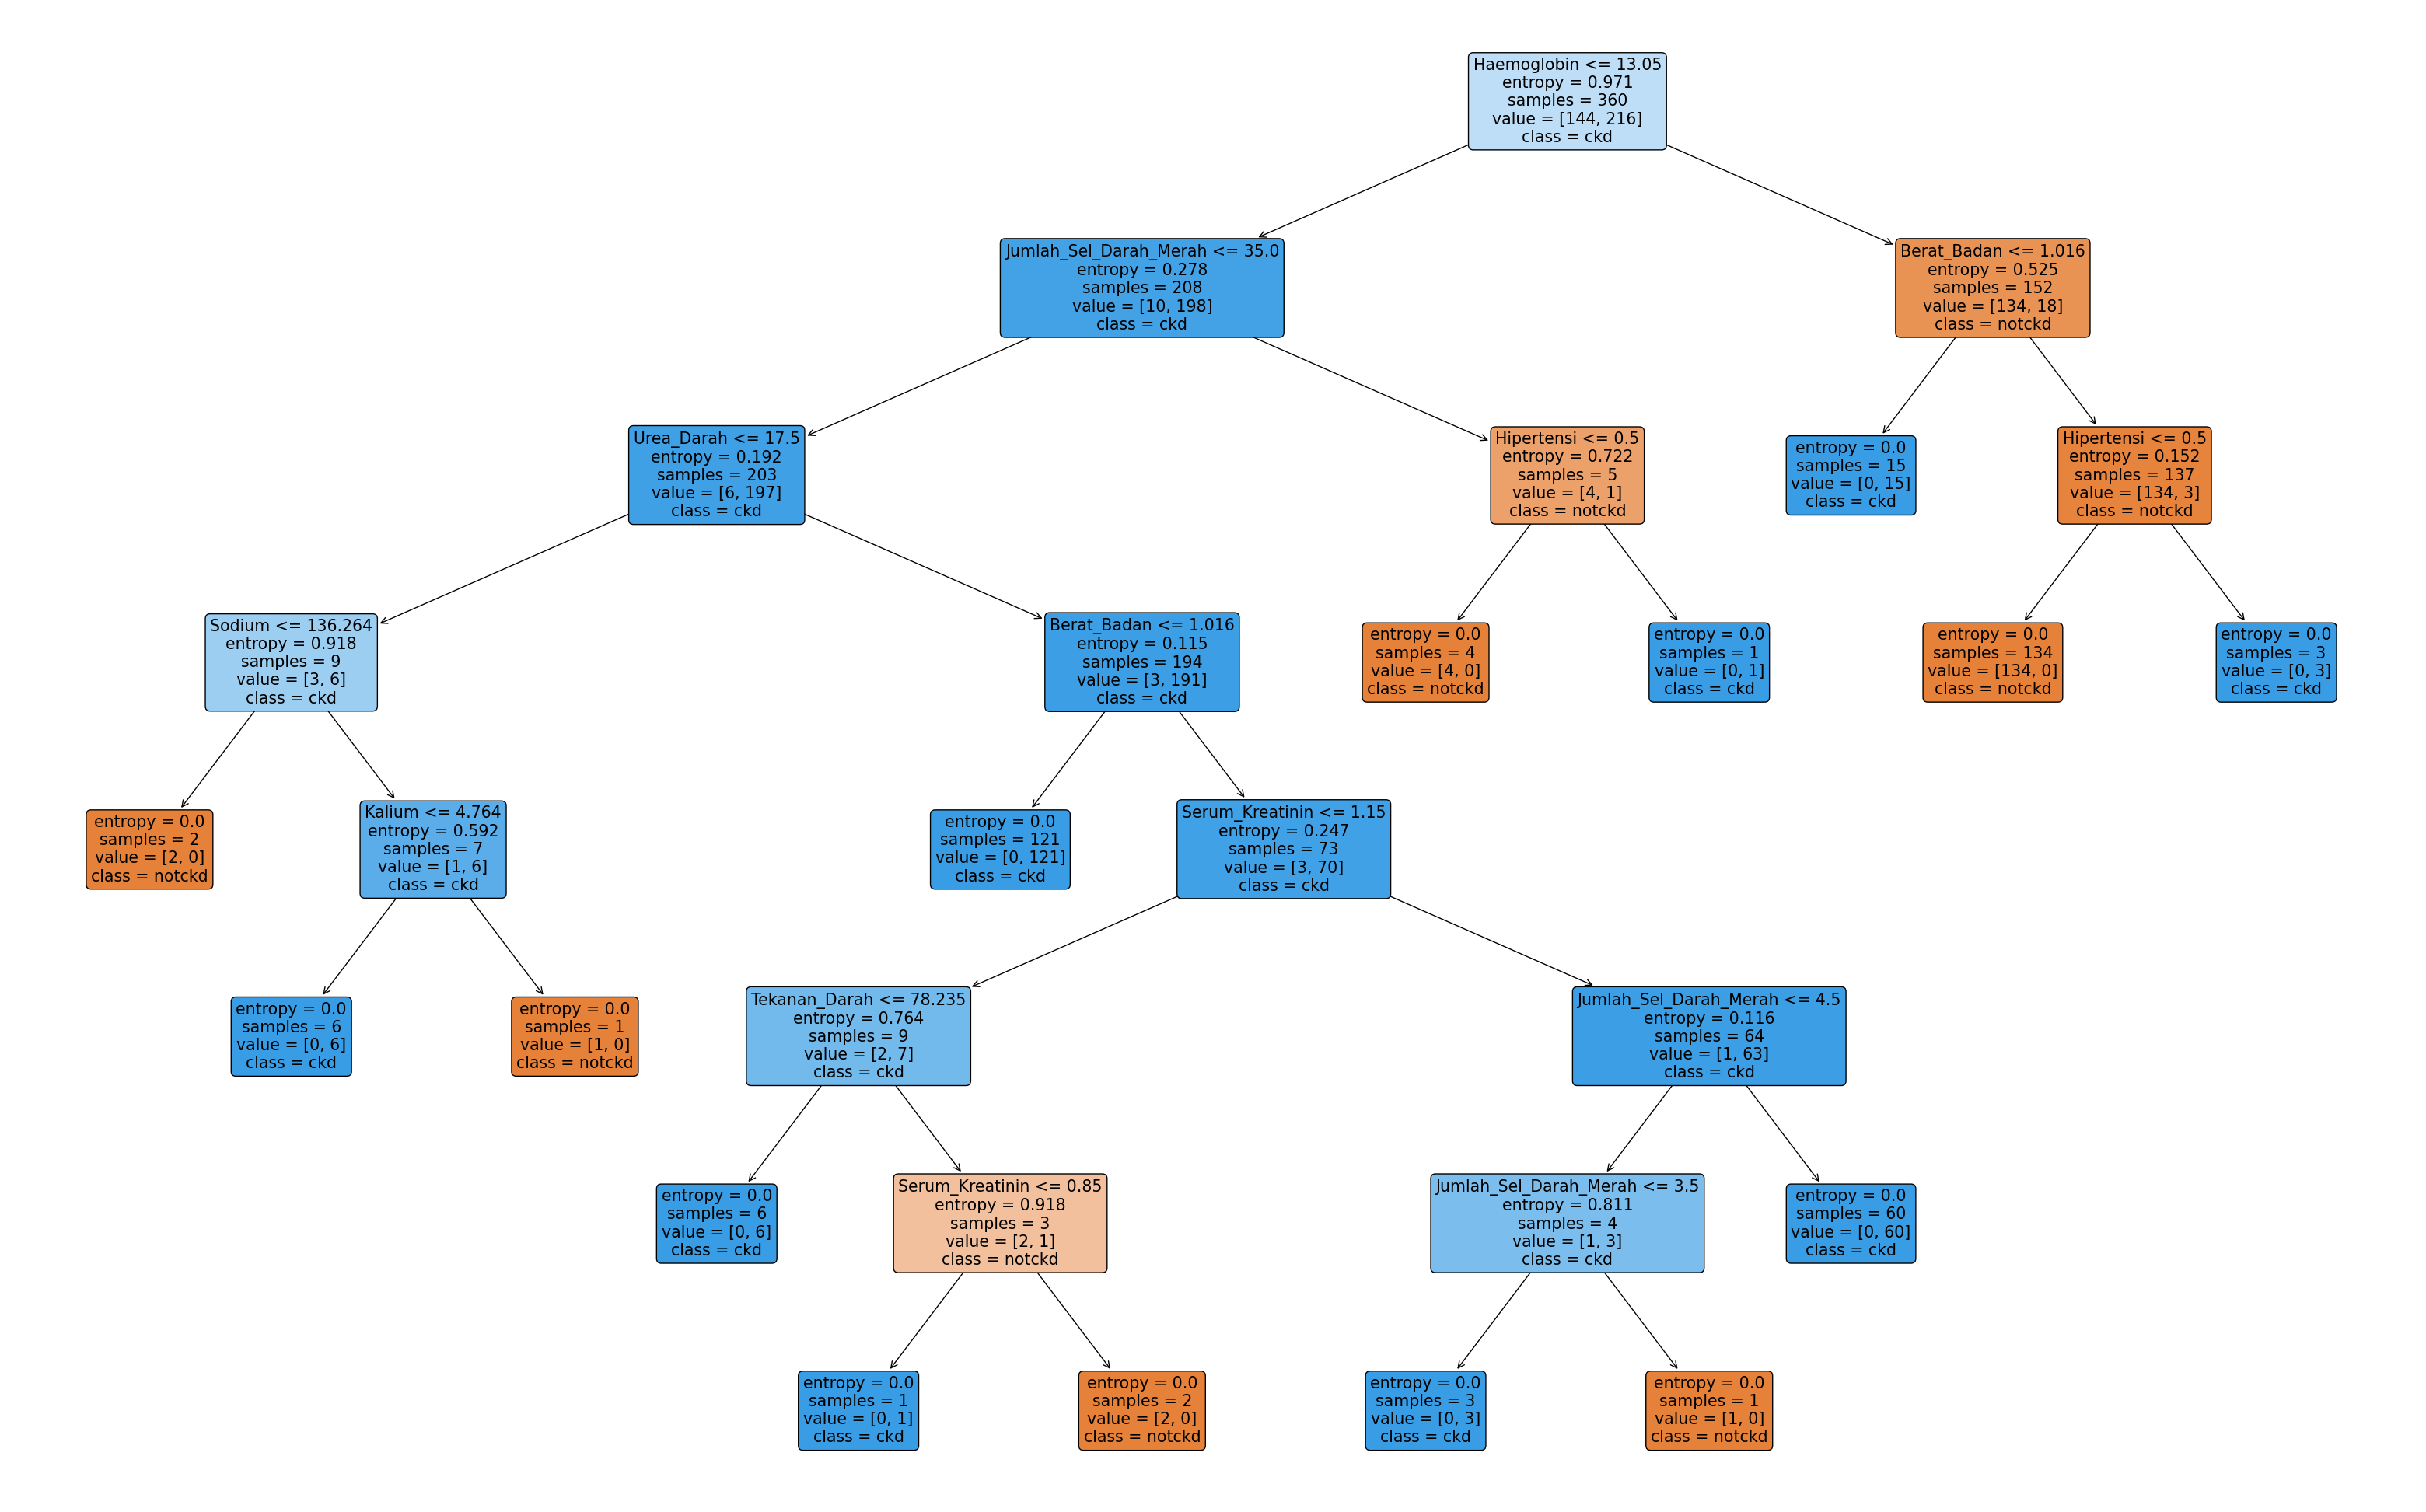

In [50]:
fig = plt.figure(figsize=(40,25))
_= tree.plot_tree(dtc_en,
                feature_names=df_columns,
                class_names=['notckd','ckd'],
                filled=True, rounded=True)

DECISION TREE + K-FOLD CROSS-VALIDATION

In [51]:
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import numpy as np

# Memisahkan fitur dan label
X = df.drop(['Class'], axis=1)  # X nya adalah atribut yang mempengaruhi penyakit jantung
y = df['Class']  # y nya adalah label itu sendiri

# Inisialisasi model Decision Tree
dtc = DecisionTreeClassifier(random_state=5)

# Menentukan KFold Cross-Validation (10 fold)
kf = KFold(n_splits=10, shuffle=True, random_state=5)

# Menyimpan hasil evaluasi untuk setiap fold
accuracies = []
precisions = []
recalls = []
f1_scores = []

# Melakukan cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Melatih model
    dtc.fit(X_train, y_train)

    # Melakukan prediksi
    dtc_predictions = dtc.predict(X_test)

    # Menghitung metrik evaluasi
    accuracy = accuracy_score(y_test, dtc_predictions)
    precision = precision_score(y_test, dtc_predictions, average='weighted')
    recall = recall_score(y_test, dtc_predictions, average='weighted')
    f1 = f1_score(y_test, dtc_predictions, average='weighted')

    # Menyimpan hasil metrik evaluasi
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Menghitung rata-rata metrik evaluasi
print("Average Accuracy: {:.2f}%".format(np.mean(accuracies) * 100))
print("Average Precision: {:.2f}%".format(np.mean(precisions) * 100))
print("Average Recall: {:.2f}%".format(np.mean(recalls) * 100))
print("Average F1-Score: {:.2f}%".format(np.mean(f1_scores) * 100))

# Menampilkan classification report untuk fold terakhir (untuk contoh)
print("\nClassification Report (Fold 10):\n", classification_report(y_test, dtc_predictions))

# Menampilkan confusion matrix untuk fold terakhir
print("\nConfusion Matrix (Fold 10):\n", confusion_matrix(y_test, dtc_predictions))


Average Accuracy: 94.75%
Average Precision: 94.83%
Average Recall: 94.75%
Average F1-Score: 94.76%

Classification Report (Fold 10):
               precision    recall  f1-score   support

         CKD       1.00      1.00      1.00         8
      NotCKD       1.00      1.00      1.00        32

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40


Confusion Matrix (Fold 10):
 [[ 8  0]
 [ 0 32]]


In [52]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Memisahkan atribut (X) dan label (y)
X = df.drop(['Class'], axis=1)  # Atribut yang mempengaruhi penyakit jantung
y = df['Class']  # Label yang berisi kelas

# Membuat model decision tree
dtc = DecisionTreeClassifier(random_state=5)

# Menentukan K-fold Cross Validation
kf = KFold(n_splits=10, shuffle=True, random_state=5)


# Melakukan K-fold Cross Validation
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

# Melakukan iterasi untuk setiap fold
for train_index, test_index in kf.split(X):
    # Membagi data berdasarkan fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Melatih model pada data latih
    dtc.fit(X_train, y_train)
    
    # Melakukan prediksi dengan data uji
    dtc_predictions = dtc.predict(X_test)
    
    # Menghitung metrik evaluasi untuk setiap fold
    accuracy_list.append(accuracy_score(y_test, dtc_predictions))
    precision_list.append(precision_score(y_test, dtc_predictions, average='weighted'))
    recall_list.append(recall_score(y_test, dtc_predictions, average='weighted'))
    f1_list.append(f1_score(y_test, dtc_predictions, average='weighted'))

# Menampilkan rata-rata metrik dari K-fold Cross Validation
print(f"Average Accuracy: {np.mean(accuracy_list) * 100:.2f}%")
print(f"Average Precision: {np.mean(precision_list) * 100:.2f}%")
print(f"Average Recall: {np.mean(recall_list) * 100:.2f}%")
print(f"Average F1 Score: {np.mean(f1_list) * 100:.2f}%")


Average Accuracy: 94.75%
Average Precision: 94.83%
Average Recall: 94.75%
Average F1 Score: 94.76%


In [53]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report, f1_score, recall_score, precision_score
from sklearn.model_selection import cross_val_score
import pandas as pd

# Asumsi: df adalah DataFrame yang memuat data
# Memisahkan fitur dan target
X = df.drop(columns='Class').values  # Mengambil semua kolom kecuali 'Class'
y = df['Class'].values  

# Inisialisasi model Decision Tree
dtc = DecisionTreeClassifier()

# Inisialisasi KFold dengan k=10
kf = KFold(n_splits=10, shuffle=True, random_state=5)
accuracies = []
f1_scores = []
recalls = []
precisions = []

# Melakukan K-Fold Cross-Validation secara manual
for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    # Memisahkan data training dan testing
    X_train, X_test = X[train_index], X[test_index]  
    y_train, y_test = y[train_index], y[test_index]  
    
    # Melatih model
    dtc.fit(X_train, y_train)
    
    # Melakukan prediksi dengan data uji
    dtc_predictions = dtc.predict(X_test)
    
    # Menghitung metrik
    accuracy = accuracy_score(y_test, dtc_predictions)
    f1 = f1_score(y_test, dtc_predictions, average='weighted')
    recall = recall_score(y_test, dtc_predictions, average='weighted')
    precision = precision_score(y_test, dtc_predictions, average='weighted')
    
    # Menyimpan metrik untuk setiap fold
    accuracies.append(accuracy)
    f1_scores.append(f1)
    recalls.append(recall)
    precisions.append(precision)
    
    # Menampilkan hasil prediksi dan metrik untuk setiap fold
    print(f"Fold {fold}")
    print(classification_report(y_test, dtc_predictions))
    print(f"Accuracy: {accuracy:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Precision: {precision:.2f}")
    print("")

# Menghitung rata-rata dari semua metrik
mean_accuracy = np.mean(accuracies)
mean_f1 = np.mean(f1_scores)
mean_recall = np.mean(recalls)
mean_precision = np.mean(precisions)

print(f"Mean Accuracy: {mean_accuracy:.2f}")
print(f"Mean F1 Score: {mean_f1:.2f}")
print(f"Mean Recall: {mean_recall:.2f}")
print(f"Mean Precision: {mean_precision:.2f}")

# Cross-validation menggunakan sklearn untuk mengukur akurasi
scores = cross_val_score(dtc, X, y, cv=kf, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {scores}")
print(f"Mean Cross-Validation Accuracy: {scores.mean():.2f}")


Fold 1
              precision    recall  f1-score   support

         CKD       0.95      0.95      0.95        19
      NotCKD       0.95      0.95      0.95        21

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40

Accuracy: 0.95
F1 Score: 0.95
Recall: 0.95
Precision: 0.95

Fold 2
              precision    recall  f1-score   support

         CKD       0.94      0.94      0.94        18
      NotCKD       0.95      0.95      0.95        22

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40

Accuracy: 0.95
F1 Score: 0.95
Recall: 0.95
Precision: 0.95

Fold 3
              precision    recall  f1-score   support

         CKD       0.80      0.86      0.83        14
      NotCKD       0.92      0.88      0.90        26

    accuracy                           0.

In [54]:
import pickle

In [57]:
# Simpan model ke file .pkl
with open('decision_tree_aja.pkl', 'wb') as file:
    pickle.dump(dtc, file)

print("Model Decision Tree berhasil disimpan sebagai decision_tree_aja.pkl")

Model Decision Tree berhasil disimpan sebagai decision_tree_aja.pkl


In [58]:
# Muat model dari file .pkl
with open('decision_tree_aja.pkl', 'rb') as file:
    loaded_dt_model = pickle.load(file)

# Gunakan model untuk prediksi
predictions = loaded_dt_model.predict(X_test)
print("Prediksi:", predictions)

Prediksi: ['NotCKD' 'NotCKD' 'NotCKD' 'NotCKD' 'NotCKD' 'NotCKD' 'NotCKD' 'NotCKD'
 'NotCKD' 'NotCKD' 'NotCKD' 'NotCKD' 'NotCKD' 'NotCKD' 'NotCKD' 'NotCKD'
 'NotCKD' 'NotCKD' 'NotCKD' 'NotCKD' 'NotCKD' 'NotCKD' 'NotCKD' 'NotCKD'
 'NotCKD' 'NotCKD' 'NotCKD' 'NotCKD' 'NotCKD' 'NotCKD' 'NotCKD' 'NotCKD'
 'CKD' 'CKD' 'CKD' 'CKD' 'CKD' 'CKD' 'CKD' 'CKD']
